## Projeto de Formação de Cientista de Dados da Data Science Academy
### Projeto com Feedback 7

### Medicina Personalizada 

### Redefindo o Tratamento de Cancer


Muito tem sido dito durante os últimos anos sobre como a medicina de precisão e, mais concretamente, como o teste genético, vai provocar disrupção no tratamento de doenças como o câncer. Mas isso ainda está acontecendo apenas parcialmente devido à enorme quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar a medicina personalizada ao seu potencial máximo. Uma vez sequenciado, um tumor cancerígeno pode ter milhares de mutações genéticas. O desafio é distinguir as mutações que contribuem para o crescimento do tumor das mutações. 

Atualmente, esta interpretação de mutações genéticas está sendo feita manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem que revisar manualmente e classificar cada mutação genética com base em evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) está disponibilizando uma base de conhecimento anotada por especialistas, onde pesquisadores e oncologistas de nível mundial anotaram manualmente milhares de mutações. 

**O objetivo deste projeto é  desenvolver um algoritmo de Aprendizado de Máquina que, usando essa base de conhecimento como uma linha de base, classifica automaticamente as variações genéticas.**


#### Bibliotecas utilizadas

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
import sklearn
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Carregando os dados

#### Utilizando o arquivo completo disponibilizado em  https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

#### Descrição dos Arquivos
- training_variants - um arquivo separado por vírgula contendo a descrição das mutações genéticas usadas para treinamento. Os campos são:
    - ID: o id da linha usada para vincular a mutação à evidência clínica       
    - Gene: o gene onde esta mutação genética está localizada
    - Variation: a alteração do aminoácido para essas mutações 
    - Class: 1-9 a classe que a mutação genética foi classificada
    
- training_text - um arquivo delimitado por tubo duplo (||) que contém a evidência clínica (texto) usada para classificar as mutações genéticas. Os campos são:
    - ID: o id da linha usada para vincular a evidência clínica à mutação genética 
    - Texto: a evidência clínica usada para classificar a mutação genética
    
- stage2_test_variants - um arquivo separado por vírgula contendo a descrição das mutações genéticas usadas para treinamento. Os campos são:
    - ID o id da linha usada para vincular a mutação à evidência clínica), 
    - Gene (o gene onde esta mutação genética está localizada
    - Variation (a alteração de aminoácidos para essas mutações)
    
- stage2_test_text.csv - um arquivo delimitado por tubo duplo (||) que contém as evidências clínicas (texto) usadas para classificar as mutações genéticas. Os campos são:
    - ID  : o id da linha usada para vincular a evidência clínica à mutação genética), 
    - Texto : a evidência clínica usada para classificar a mutação genética

#### Carregando os dados de treino

In [2]:
# carregando os dados_training
dados_variante_treino = pd.read_csv('D:/FCD/MachineLearning/Cap20_ProjetosComFeedBack/Projeto_7/dados_k/training_variants')

In [3]:
# carregando dados_texto
dados_texto_treino = pd.read_csv('D:/FCD/MachineLearning/Cap20_ProjetosComFeedBack/Projeto_7/dados_k/training_text',
                          sep = "\|\|", 
                          engine="python",
                          names=["ID","TEXT"],
                          skiprows=1)

In [4]:
dados_variante_treino.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
dados_texto_treino.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# Dimensões dos dados de treino
dados_variante_treino.shape

(3321, 4)

In [7]:
dados_texto_treino.shape

(3321, 2)

In [8]:
dados_variante_treino['Class'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [9]:
treino =  pd.merge(dados_variante_treino, 
                   dados_texto_treino, 
                   on='ID',
                   how ='left').fillna('')

In [10]:
treino.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
treino.shape

(3321, 5)

#### Carregando dados de teste

In [12]:
dados_teste_texto = pd.read_csv('D:/FCD/MachineLearning/Cap20_ProjetosComFeedBack/Projeto_7/dados_k/stage2_test_text.csv',
                                sep = "\|\|", 
                                engine="python",
                                names=["ID","TEXT"],
                                skiprows=1)

In [13]:
dados_teste_variante = pd.read_csv('D:/FCD/MachineLearning/Cap20_ProjetosComFeedBack/Projeto_7/dados_k/stage2_test_variants.csv')

In [14]:
teste =  pd.merge(dados_teste_variante, 
                  dados_teste_texto,  
                  on='ID',
                  how ='left').fillna('')

In [15]:
teste.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [16]:
teste.shape

(986, 4)

In [17]:
df_completo = pd.concat([treino, teste]).reset_index(drop=True)


In [18]:
df_completo

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2.0,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2.0,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3.0,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
4302,982,TP63,S580P,NaN,IκB kinase β (IKKβ) is involved in tumor devel...
4303,983,SCN4A,R672G,NaN,he identification of subtype-specific transloc...
4304,984,BRAF,N581H,NaN,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...
4305,985,TSHR,S281N,NaN,Screening for tumor suppressor genes in breast...


In [19]:
df_completo.shape

(4307, 5)

#### Visualizando a variável Alvo

In [20]:
df_completo['Class'].value_counts().sort_index()

1.0    568
2.0    452
3.0     89
4.0    686
5.0    242
6.0    275
7.0    953
8.0     19
9.0     37
Name: Class, dtype: int64

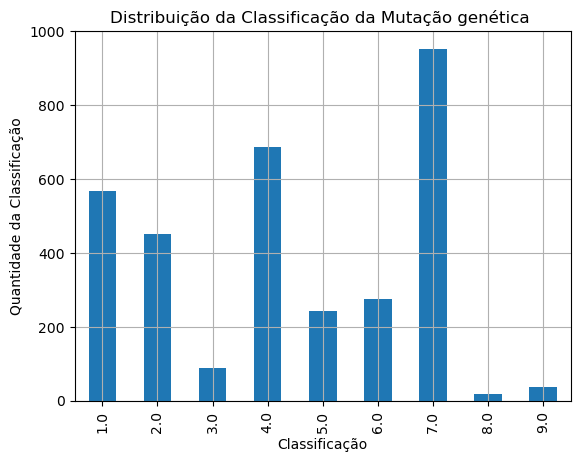

In [21]:
my_colors = 'rgbkymc'
df_completo['Class'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Classificação')
plt.ylabel('Quantidade da Classificação')
plt.title('Distribuição da Classificação da Mutação genética ')
plt.grid()
plt.show()

### Preparação da coluna TEXT

#### Covertendo o texto para letras minúsculas

In [22]:
# Covertendo o texto para minúscula
df_completo["TEXT"] = df_completo["TEXT"].apply(lambda x : " ".join(i.lower() for i in x.split()))

In [23]:
df_completo.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,cyclin-dependent kinases (cdks) regulate a var...
1,1,CBL,W802*,2.0,abstract background non-small cell lung cancer...
2,2,CBL,Q249E,2.0,abstract background non-small cell lung cancer...
3,3,CBL,N454D,3.0,recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,oncogenic mutations in the monomeric casitas b...


#### Removendo a pontuação

In [24]:
df_completo["TEXT"] = df_completo["TEXT"].str.replace("[^\w\s]","")
df_completo.head()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_7776\1133249465.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_completo["TEXT"] = df_completo["TEXT"].str.replace("[^\w\s]","")


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,cyclindependent kinases cdks regulate a variet...
1,1,CBL,W802*,2.0,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2.0,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3.0,recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,oncogenic mutations in the monomeric casitas b...


#### Remoção de valores numéricos

In [25]:
df_completo["TEXT"] = df_completo["TEXT"].str.replace("\d", "")
df_completo.head()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_7776\355579040.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_completo["TEXT"] = df_completo["TEXT"].str.replace("\d", "")


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,cyclindependent kinases cdks regulate a variet...
1,1,CBL,W802*,2.0,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2.0,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3.0,recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,oncogenic mutations in the monomeric casitas b...


#### Remoção de stopwords

In [26]:
nltk.download("stopwords")
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Francisco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df_completo["TEXT"] = df_completo["TEXT"].apply(lambda x : " ".join(i for i in x.split() if i not in sw))

In [28]:
df_completo.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,cyclindependent kinases cdks regulate variety ...
1,1,CBL,W802*,2.0,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2.0,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4.0,oncogenic mutations monomeric casitas blineage...


#### Tokenização da coluna TEXT

In [29]:
df_completo["TEXT"] = df_completo["TEXT"].apply(lambda x : word_tokenize(x) )

In [30]:
df_completo.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,"[cyclindependent, kinases, cdks, regulate, var..."
1,1,CBL,W802*,2.0,"[abstract, background, nonsmall, cell, lung, c..."
2,2,CBL,Q249E,2.0,"[abstract, background, nonsmall, cell, lung, c..."
3,3,CBL,N454D,3.0,"[recent, evidence, demonstrated, acquired, uni..."
4,4,CBL,L399V,4.0,"[oncogenic, mutations, monomeric, casitas, bli..."


#### Lematização

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Francisco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
wordnet_lemmatizer = WordNetLemmatizer()
df_completo["TEXT"] = df_completo["TEXT"].apply(lambda x : " ".join(wordnet_lemmatizer.lemmatize(word) for word in x))

In [33]:
df_completo.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,cyclindependent kinase cdks regulate variety f...
1,1,CBL,W802*,2.0,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2.0,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4.0,oncogenic mutation monomeric casitas blineage ...


#### Vetorização do texto

In [34]:
def Vectorize_text(text, max_features=250, ngram_range=(1, 2), min_df=1):
    X_vect = list(text)
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range, max_features=max_features)
    X_vect = pd.DataFrame(tfidf.fit_transform(X_vect).toarray(), index=text.index)      
    return X_vect

In [35]:
tfidf_df_completo = Vectorize_text(df_completo['TEXT'])

In [36]:
tfidf_df_completo

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.006793,0.034975,0.007890,0.015727,0.006018,0.014711,0.060916,0.000000,0.017664,0.000000,...,0.043877,0.000000,0.016479,0.012109,0.030082,0.011653,0.017443,0.020121,0.018961,0.080899
1,0.000000,0.004740,0.006416,0.012790,0.014682,0.000000,0.067553,0.027344,0.009577,0.008343,...,0.000000,0.000000,0.035736,0.004924,0.009785,0.033168,0.004728,0.016363,0.020559,0.039474
2,0.000000,0.004740,0.006416,0.012790,0.014682,0.000000,0.067553,0.027344,0.009577,0.008343,...,0.000000,0.000000,0.035736,0.004924,0.009785,0.033168,0.004728,0.016363,0.020559,0.039474
3,0.006840,0.017608,0.015888,0.023753,0.012119,0.000000,0.089216,0.005643,0.017786,0.000000,...,0.000000,0.000000,0.038716,0.024386,0.042405,0.093866,0.011709,0.040520,0.006364,0.000000
4,0.010368,0.008897,0.024083,0.000000,0.068885,0.078583,0.126780,0.004276,0.013480,0.000000,...,0.000000,0.005703,0.004192,0.018482,0.004591,0.080033,0.017748,0.010237,0.019292,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.022799,0.019564,0.000000,0.000000,0.060591,0.000000,0.060404,0.014106,0.014821,0.008607,...,0.026296,0.025083,0.004609,0.010160,0.070673,0.024443,0.004878,0.084413,0.010606,0.000000
4303,0.014302,0.000000,0.005537,0.011037,0.016893,0.000000,0.015545,0.011798,0.008264,0.007199,...,0.004399,0.036714,0.015419,0.012747,0.004222,0.008178,0.024482,0.018828,0.004435,0.005677
4304,0.005033,0.023755,0.017538,0.011653,0.033442,0.019075,0.045136,0.006228,0.006544,0.000000,...,0.002322,0.000000,0.018315,0.013459,0.002229,0.012951,0.006462,0.000000,0.004683,0.000000
4305,0.086226,0.008221,0.011127,0.011090,0.067897,0.000000,0.015620,0.007903,0.024912,0.000000,...,0.017680,0.010540,0.023241,0.008539,0.016970,0.000000,0.016400,0.000000,0.000000,0.000000


#### Redução de dimensionalidade 

In [37]:
svd = TruncatedSVD(n_components=50, n_iter=5, random_state=0)
truncated_tfidf = svd.fit_transform(tfidf_df_completo)
df_tfidf_col_name = ["tfidf_"+str(i) for i in range(50)]
df_tfidf = pd.DataFrame(truncated_tfidf)
df_tfidf.columns = df_tfidf_col_name

In [38]:
df_tfidf[:3]

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
0,0.676442,-0.091621,0.027708,-0.358904,-0.066043,-0.071911,0.081237,0.023904,-0.050549,-0.047996,...,0.025002,0.007788,-0.079287,-0.035413,-0.008365,-0.145414,0.038099,0.008592,-0.008954,0.033273
1,0.728735,-0.143402,-0.260027,0.040864,-0.123732,0.138553,0.058910,0.157008,-0.156701,0.071780,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835
2,0.728735,-0.143402,-0.260027,0.040864,-0.123732,0.138553,0.058910,0.157008,-0.156701,0.071780,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835


#### Preparação das colunas "Gene e Variation"

In [39]:
df_completo['Gene'] = df_completo['Gene'].str.replace('\s+','_')


C:\Users\Francisco\AppData\Local\Temp\ipykernel_7776\1219796665.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_completo['Gene'] = df_completo['Gene'].str.replace('\s+','_')


In [40]:
df_completo['Variation'] =df_completo['Variation'].str.replace('\s+','_')

C:\Users\Francisco\AppData\Local\Temp\ipykernel_7776\2917818412.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_completo['Variation'] =df_completo['Variation'].str.replace('\s+','_')


#### Convertendo as colunas Gene e Variation para variáveis Dummy

In [41]:
df_completo = pd.get_dummies(df_completo, columns =['Gene', 'Variation'], drop_first = True)

#### Juntando os dataframes

In [42]:
df_completo = df_completo.join(df_tfidf)

In [43]:
df_completo.head()

,ID,Class,TEXT,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,Gene_AGXT,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
0,0,1.0,cyclindependent kinase cdks regulate variety f...,0,0,0,0,0,0,0,...,0.025002,0.007788,-0.079287,-0.035413,-0.008365,-0.145414,0.038099,0.008592,-0.008954,0.033273
1,1,2.0,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,0,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835
2,2,2.0,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,0,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835
3,3,3.0,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,0,...,-0.028847,-0.043798,-0.049319,-0.215931,0.056824,-0.036638,-0.017131,0.033326,-0.090691,-0.090819
4,4,4.0,oncogenic mutation monomeric casitas blineage ...,0,0,0,0,0,0,0,...,-0.066614,0.006858,0.105664,-0.012777,0.001065,0.030206,-0.113013,0.038056,-0.109739,0.042495


In [44]:
df_completo.shape

(4307, 4373)

#### Dividindo os dados

In [45]:
df_treino = df_completo.iloc[:treino.shape[0]]
df_teste = df_completo.iloc[treino.shape[0]:]

In [46]:
df_treino.head()

,ID,Class,TEXT,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,Gene_AGXT,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
0,0,1.0,cyclindependent kinase cdks regulate variety f...,0,0,0,0,0,0,0,...,0.025002,0.007788,-0.079287,-0.035413,-0.008365,-0.145414,0.038099,0.008592,-0.008954,0.033273
1,1,2.0,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,0,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835
2,2,2.0,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,0,...,-0.099003,0.056075,0.035721,0.038377,0.055139,-0.112004,-0.061963,-0.095066,-0.063846,0.039835
3,3,3.0,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,0,...,-0.028847,-0.043798,-0.049319,-0.215931,0.056824,-0.036638,-0.017131,0.033326,-0.090691,-0.090819
4,4,4.0,oncogenic mutation monomeric casitas blineage ...,0,0,0,0,0,0,0,...,-0.066614,0.006858,0.105664,-0.012777,0.001065,0.030206,-0.113013,0.038056,-0.109739,0.042495


In [47]:
df_treino.shape

(3321, 4373)

In [48]:
df_teste.head()

,ID,Class,TEXT,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,Gene_AGXT,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
3321,1,NaN,incidence breast cancer increasing china recen...,0,0,0,0,0,0,0,...,0.009091,-0.144264,-0.057730,-0.012888,-0.036464,-0.010838,-0.034021,0.085790,0.032768,0.001860
3322,2,NaN,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,...,-0.022445,-0.012641,-0.012858,-0.002049,-0.032133,-0.008618,0.054502,0.099832,0.046346,0.012891
3323,3,NaN,mycosis fungoides sézary syndrome primary cuta...,0,0,0,0,0,0,0,...,0.011880,0.014420,0.026516,-0.027314,0.059166,-0.113075,-0.032494,0.037902,-0.037015,-0.068597
3324,4,NaN,regulated progression cell cycle requires sequ...,0,0,0,0,0,0,0,...,-0.020056,0.009782,0.065508,0.018934,-0.014479,0.022317,-0.025986,0.062642,-0.031323,-0.042569
3325,5,NaN,pilocytic astrocytoma pa emerging tumor entity...,0,0,0,0,0,0,0,...,0.029631,-0.017060,-0.008344,-0.017931,0.014351,0.002221,-0.021601,-0.005874,0.032701,-0.023451


In [49]:
df_teste.shape

(986, 4373)

In [50]:
X = df_treino.iloc[:, 3:]
y = df_treino['Class']

In [51]:
X_teste = df_teste.iloc[:, 3:]

#### Dividindo os dados de treino em treino e validação

In [52]:
X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size = 0.2, random_state=10)

### Criação do 1º modelo com XGBClassifier

In [53]:
from xgboost import XGBClassifier

In [54]:
# As classes são reconhecidas a partir de 0, então subtraímos 1 para que o algoritmo 
# comece corretamente, depois adicionamos em nossa previsão
y_treino = y_treino-1

#### Procurando hiperparâmetros

In [55]:
from sklearn.model_selection import cross_val_score

# Cria o modelo XGBClassifier
xgb = XGBClassifier(
    objective = 'multi:softprob',
    eval_metric = 'mlogloss',
    num_class = 9,
    nthread=4,
    seed=10
)

# define os hiperparâmetros que serão ajustados
parameters = {'max_depth': range(4, 7, 1),'learning_rate': [0.1, 0.01, 0.05]}
            
              

# Realiza GridSerchCV para ajuste dos hiperparâmetros
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    n_jobs = 10,
    cv = 3,
    verbose=True
)

grid_search.fit(X_treino, y_treino)

# Melhores hiperparâmetros encontrados pelo GridSearchCV
melhores_hiperparametros = grid_search.best_params_

# Criar o modelo final com os melhores hiperparâmetros
melhor_xgb_model = XGBClassifier(objective = 'multi:softprob', 
                                 eval_metric = 'mlogloss',
                                 num_class = 9,
                                 nthread=4,
                                 seed=10, 
                                 **melhores_hiperparametros)




Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\Francisco\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Validação Cruzada

In [56]:
# Realizar validação cruzada com o modelo final
cv_scores = cross_val_score(melhor_xgb_model, X_treino, y_treino, cv=3)

In [57]:
# Exibir os resultados
print("Melhores hiperparâmetros:", melhores_hiperparametros)
print("Resultados da validação cruzada:", cv_scores)
print("Média dos resultados:", cv_scores.mean())

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 5}
Resultados da validação cruzada: [0.64559819 0.62711864 0.65423729]
Média dos resultados: 0.6423180421114384


#### Treina e avalia o modelo

In [58]:
import xgboost as xgb
deval_xgb = xgb.DMatrix(X_val, label = y_val-1)
dtrain_xgb = xgb.DMatrix(X_treino, label = y_treino)

In [59]:
evallist = [(dtrain_xgb, 'train'), (deval_xgb, 'eval')]

In [60]:
xgb_param = {'objective': 'multi:softprob',
          'eval_metric' : 'mlogloss',
          'learning_rate' : 0.1,
          'max_depth' : 5,
          'num_class' : 9,
          'nthread': 4,
          'seed': 10}
xgb_cl = xgb.train(xgb_param, dtrain_xgb, evals=evallist, early_stopping_rounds=50)

[0]	train-mlogloss:2.03337	eval-mlogloss:2.05196
[1]	train-mlogloss:1.90138	eval-mlogloss:1.93673
[2]	train-mlogloss:1.79060	eval-mlogloss:1.84110
[3]	train-mlogloss:1.69423	eval-mlogloss:1.75860
[4]	train-mlogloss:1.60807	eval-mlogloss:1.68463
[5]	train-mlogloss:1.53268	eval-mlogloss:1.62050
[6]	train-mlogloss:1.46747	eval-mlogloss:1.56740
[7]	train-mlogloss:1.40742	eval-mlogloss:1.51707
[8]	train-mlogloss:1.35558	eval-mlogloss:1.47501
[9]	train-mlogloss:1.30807	eval-mlogloss:1.43738


In [61]:
xgb_cl.attributes()

{'best_iteration': '9',
 'best_ntree_limit': '10',
 'best_score': '1.437380700272725'}

#### Fazendo as Previsões com dados de teste

In [62]:
xgtest = xgb.DMatrix(X_teste)

In [63]:
xgtest

In [64]:
y_pred = xgb_cl.predict(xgtest)

In [65]:
y_pred

array([[0.18215494, 0.07217823, 0.18976267, ..., 0.09381425, 0.07137804,
        0.07113619],
       [0.519802  , 0.06229101, 0.04888836, ..., 0.08195212, 0.0468269 ,
        0.04667738],
       [0.11169332, 0.12709747, 0.09902179, ..., 0.13973077, 0.09486496,
        0.09454353],
       ...,
       [0.06527696, 0.16156235, 0.06617651, ..., 0.36310667, 0.0633985 ,
        0.06318369],
       [0.15805621, 0.13782482, 0.07896536, ..., 0.16536151, 0.07565048,
        0.07539415],
       [0.06430899, 0.17426173, 0.06519521, ..., 0.36344227, 0.06377067,
        0.06224676]], dtype=float32)

In [66]:
classes = ['class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']
submit = pd.DataFrame(y_pred, columns=classes)
submit['ID'] = teste['ID'].values

In [67]:
submit = submit[['ID', 'class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']]

In [68]:
submit 


,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.182155,0.072178,0.189763,0.119743,0.118168,0.081665,0.093814,0.071378,0.071136
1,2,0.519802,0.062291,0.048888,0.087441,0.052916,0.053206,0.081952,0.046827,0.046677
2,3,0.111693,0.127097,0.099022,0.118102,0.107179,0.107767,0.139731,0.094865,0.094544
3,4,0.203804,0.120549,0.074567,0.120575,0.080710,0.081153,0.176010,0.071437,0.071195
4,5,0.064091,0.163866,0.064974,0.066920,0.070327,0.070862,0.374676,0.062247,0.062036
...,...,...,...,...,...,...,...,...,...,...
981,982,0.136233,0.121941,0.075755,0.134584,0.081996,0.083035,0.221552,0.072575,0.072329
982,983,0.099817,0.166563,0.069231,0.072499,0.074934,0.075346,0.304297,0.071212,0.066100
983,984,0.065277,0.161562,0.066177,0.073494,0.071628,0.072173,0.363107,0.063398,0.063184
984,985,0.158056,0.137825,0.078965,0.137338,0.085470,0.085940,0.165362,0.075650,0.075394


In [77]:
submit['maior_probabilidade'] = submit.iloc[:, 1:].max(axis=1)
submit['classe_associada'] = submit.iloc[:, 1:].idxmax(axis=1).str.replace('class', '').astype(int)


In [78]:
submit

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9,maior_probabilidade,classe_associada
0,1,0.182155,0.072178,0.189763,0.119743,0.118168,0.081665,0.093814,0.071378,0.071136,0.189763,3
1,2,0.519802,0.062291,0.048888,0.087441,0.052916,0.053206,0.081952,0.046827,0.046677,0.519802,1
2,3,0.111693,0.127097,0.099022,0.118102,0.107179,0.107767,0.139731,0.094865,0.094544,0.139731,7
3,4,0.203804,0.120549,0.074567,0.120575,0.080710,0.081153,0.176010,0.071437,0.071195,0.203804,1
4,5,0.064091,0.163866,0.064974,0.066920,0.070327,0.070862,0.374676,0.062247,0.062036,0.374676,7
...,...,...,...,...,...,...,...,...,...,...,...,...
981,982,0.136233,0.121941,0.075755,0.134584,0.081996,0.083035,0.221552,0.072575,0.072329,0.221552,7
982,983,0.099817,0.166563,0.069231,0.072499,0.074934,0.075346,0.304297,0.071212,0.066100,0.304297,7
983,984,0.065277,0.161562,0.066177,0.073494,0.071628,0.072173,0.363107,0.063398,0.063184,0.363107,7
984,985,0.158056,0.137825,0.078965,0.137338,0.085470,0.085940,0.165362,0.075650,0.075394,0.165362,7


In [69]:
submit.to_csv('submission1.csv', index=False)

### Criação do 2º modelo com Deep Learning

In [84]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar seus dados (X_treino e y_treino)
# Substitua esta parte pelo carregamento dos seus próprios dados

# Dividir os dados em conjuntos de treinamento e teste
X_treino_rnn, X_val_rnn, y_treino_rnn, y_val_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar os dados
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino_rnn)
X_teste_scaled = scaler.transform(X_teste)
X_val_rnn_scaled = scaler.transform(X_val_rnn)
# Definir o modelo da rede neural com dropout
modelo = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_treino_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adicionar camada de dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adicionar camada de dropout
    tf.keras.layers.Dense(9, activation='softmax')  # Número de classes
])

# Compilar o modelo
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Treinar o modelo
modelo.fit(X_treino_scaled, y_treino_rnn-1, epochs=10, batch_size=32, validation_data=(X_val_rnn_scaled, y_val_rnn-1))




Epoch 1/10
83/83 [==============================] - 2s 13ms/step - loss: 2.5624 - accuracy: 0.1811 - val_loss: 1.9768 - val_accuracy: 0.3429
Epoch 2/10
83/83 [==============================] - 1s 12ms/step - loss: 1.9387 - accuracy: 0.3099 - val_loss: 1.8621 - val_accuracy: 0.3985
Epoch 3/10
83/83 [==============================] - 1s 11ms/step - loss: 1.6529 - accuracy: 0.3998 - val_loss: 1.7734 - val_accuracy: 0.4226
Epoch 4/10
83/83 [==============================] - 1s 11ms/step - loss: 1.3998 - accuracy: 0.5053 - val_loss: 1.6752 - val_accuracy: 0.4617
Epoch 5/10
83/83 [==============================] - 1s 11ms/step - loss: 1.0980 - accuracy: 0.6235 - val_loss: 1.5742 - val_accuracy: 0.5053
Epoch 6/10
83/83 [==============================] - 1s 13ms/step - loss: 0.8794 - accuracy: 0.7063 - val_loss: 1.4975 - val_accuracy: 0.5158
Epoch 7/10
83/83 [==============================] - 1s 11ms/step - loss: 0.6665 - accuracy: 0.7748 - val_loss: 1.4518 - val_accuracy: 0.5323
Epoch 8/10
83

In [102]:
modelo.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4319828>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5413534>}

#### Fazendo previsões com dados de teste

In [85]:
# Fazer previsões com o modelo treinado
y_pred_prob= modelo.predict(X_teste_scaled)
y_pred_rnn = y_pred_prob.argmax(axis=-1)

31/31 [==============================] - 0s 3ms/step


In [86]:
classes = ['class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']
submit_nn = pd.DataFrame(y_pred_prob, columns=classes)
submit_nn['ID'] = teste['ID'].values
submit_nn = submit_nn[['ID', 'class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']]
submit_nn['maior_probabilidade'] = submit_nn.iloc[:, 1:].max(axis=1)
submit_nn['classe_associada'] = submit_nn.iloc[:, 1:].idxmax(axis=1).str.replace('class', '').astype(int)


In [87]:
submit_nn

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9,maior_probabilidade,classe_associada
0,1,0.048974,0.056295,0.045087,0.222822,0.059225,0.422188,0.098210,0.023635,0.023563,0.422188,6
1,2,0.879561,0.029878,0.003548,0.024154,0.017239,0.012872,0.026939,0.004575,0.001233,0.879561,1
2,3,0.208093,0.175508,0.057168,0.111626,0.094193,0.106801,0.144268,0.053495,0.048846,0.208093,1
3,4,0.286592,0.163522,0.046181,0.111931,0.085145,0.093201,0.128134,0.047713,0.037581,0.286592,1
4,5,0.061560,0.329732,0.043862,0.033127,0.044020,0.063180,0.387951,0.016298,0.020270,0.387951,7
...,...,...,...,...,...,...,...,...,...,...,...,...
981,982,0.301873,0.157035,0.044128,0.100107,0.079526,0.102756,0.136153,0.047254,0.031168,0.301873,1
982,983,0.157023,0.247802,0.051024,0.092921,0.070638,0.118712,0.182813,0.043441,0.035626,0.247802,2
983,984,0.104963,0.295531,0.046248,0.050736,0.059171,0.095593,0.292946,0.026919,0.027892,0.295531,2
984,985,0.337995,0.170095,0.033590,0.087851,0.069857,0.090425,0.153773,0.033330,0.023084,0.337995,1
